# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
#import stuff
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import cv2
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from datetime import timedelta
from tqdm import tqdm
from math import ceil

In [2]:
# Load pickled data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']    

###basic data summary.
# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
img_size = X_train.shape[1]
img_shape = (img_size,img_size)

#shape of a flat image
img_size_flat = img_size*img_size

# TODO: how many classes are in the dataset
n_cls = len(np.unique (y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Image data size flat=", img_size_flat)
print("Number of classes =", n_cls)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Image data size flat= 1024
Number of classes = 43


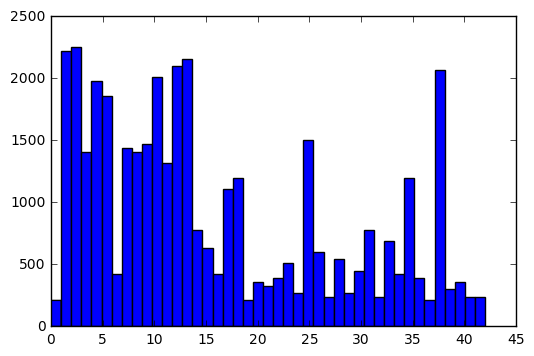

In [3]:
### Data exploration visualization goes here.
#histogram of the classes
plt.hist(y_train,bins=n_cls)  
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# Preprocess data

In [4]:
#convert images to YUV, and only leave Y channel

X_train_YUV, X_test_YUV = np.zeros_like(X_train), np.zeros_like(X_test)
X_train_Y = np.zeros((n_train,X_train.shape[1],X_train.shape[2]))
X_test_Y = np.zeros((n_test,X_test.shape[1],X_test.shape[2]))

for i in range(n_train):
    X_train_YUV[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2YUV)
    X_train_Y[i] = X_train_YUV[i][:,:,0]
    
for i in range(n_test):
    X_test_YUV[i] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2YUV)
    X_test_Y[i] = X_test_YUV[i][:,:,0]

X_train = X_train_Y
X_test = X_test_Y
    
print (X_train.shape)
print (X_test.shape)

(39209, 32, 32)
(12630, 32, 32)


#helper function to jetter data

def transform_image(img,ang_range,shear_range,trans_range):
  
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

X_train_large = np.zeros((n_train*5,32,32))
y_train_large = np.zeros((n_train*5),dtype=np.int)

for i in range(n_train*5):
    y_train_large[i] = y_train[i%n_train]
    if i > n_train:
        X_train_large[i] = transform_image(X_train[i%n_train],20,10,3)  

X_train = X_train_large
y_train = y_train_large    

plt.hist(y_train_large,bins=n_cls)  
plt.show()

In [5]:
#flatten the images
X_train = np.reshape(X_train,(-1,img_size_flat))
X_test = np.reshape(X_test,(-1,img_size_flat))

#helper function to normalize the images
def normalize_greyscale(image_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )    

#normalize the images
normalize_greyscale(X_train)
normalize_greyscale(X_test)

#split the data into training/validation/testing sets.
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.2)

#save the classes 
y_train_cls, y_validation_cls, y_test_cls = y_train, y_validation, y_test

#onehot encode labels
onehot_cls = []
for i in range (n_cls):
    onehot_cls.append(i)      
y_train = label_binarize(y_train, classes = onehot_cls)
y_validation = label_binarize(y_validation, classes = onehot_cls)
y_test = label_binarize(y_test, classes =onehot_cls)

print ('X_train shape:',X_train.shape)
print ('X_validation shape:',X_validation.shape)
print ('y_train shape:',y_train.shape)
print ('y_validation shape:',y_validation.shape)

X_train shape: (31367, 1024)
X_validation shape: (7842, 1024)
y_train shape: (31367, 43)
y_validation shape: (7842, 43)


In [9]:
# helper function for plotting traffic signs images,
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 7x7 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
usded label binarize function from sklearn to one-hot encode the y_train; turned colored images into grayscale, normalized the grayscale images; reshaped X_train, X_test to flatten the images

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:** training set : validation set = 0.8:0.2

# set up

In [7]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
n_filters1 = 32         # There are 32 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
n_filters2 = 72         # There are 72 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

In [10]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

#Helper-function for creating a new Convolutional Layer
def new_conv_layer(input,              # The previous layer.
                   n_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   n_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, n_input_channels, n_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=n_filters)
    
    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # 2x2 max-pooling
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)
    
    #dropouts
    layer = tf.nn.dropout(layer, keep_prob)

    # return both the resulting layer and the filter-weights
    return layer, weights

#Helper-function for flattening a layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    n_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, n_features])

    # Return both the flattened layer and the number of features.
    return layer_flat, n_features

#Helper-function for creating a new Fully-Connected Layer
def new_fc_layer(input,          # The previous layer.
                 n_inputs,     # Num. inputs from prev. layer.
                 n_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[n_inputs, n_outputs])
    biases = new_biases(length=n_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)
        
    #dropouts
    layer = tf.nn.dropout(layer,keep_prob)

    return layer

# network structure 

In [11]:
#Placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_conv = tf.reshape(x, [-1, img_size, img_size, 1])

y = tf.placeholder(tf.float32, shape=[None, n_cls], name='y')
y_cls = tf.argmax(y, dimension=1)

keep_prob = tf.placeholder(tf.float32)

In [12]:
#Convolutional Layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_conv,
                   n_input_channels=1,
                   filter_size=filter_size1,
                   n_filters=n_filters1,
                   use_pooling=True)
    
#Convolutional Layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   n_input_channels=n_filters1,
                   filter_size=filter_size2,
                   n_filters=n_filters2,
                   use_pooling=True)    
    
#flatten layer
layer_flat, n_features = flatten_layer(layer_conv2)    
    
#Fully-Connected Layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         n_inputs=n_features,
                         n_outputs=fc_size,
                         use_relu=True)    
    
#fully-connected layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         n_inputs=fc_size,
                         n_outputs=n_cls,
                         use_relu=False)    
    
#Predicted Class
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)    


print('1st conv layer:')
print(layer_conv1)
print('2nd conv layer:')
print(layer_conv2)
print('flatten layer:')
print(layer_flat)
print('1st fully connected layer:')
print(layer_fc1)
print('2nd fully connected layer:')
print(layer_fc2)
    

1st conv layer:
Tensor("dropout/mul:0", shape=(?, 16, 16, 32), dtype=float32)
2nd conv layer:
Tensor("dropout_1/mul:0", shape=(?, 8, 8, 72), dtype=float32)
flatten layer:
Tensor("Reshape_2:0", shape=(?, 4608), dtype=float32)
1st fully connected layer:
Tensor("dropout_2/mul:0", shape=(?, 256), dtype=float32)
2nd fully connected layer:
Tensor("dropout_3/mul:0", shape=(?, 43), dtype=float32)


In [13]:
#Cost-function to be optimized
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y)
loss = tf.reduce_mean(cross_entropy)

#Optimization Method
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss)

#Performance Measures
correct_prediction = tf.equal(y_pred_cls, y_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Training

In [14]:
#parameter configurations
epochs = 1
batch_size = 100
learning_rate = 0.0001

In [ ]:
# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# The accuracy measured against the validation set
validation_accuracy = 0.0

session = tf.Session()
session.run(tf.initialize_all_variables())
batch_count = int(ceil(len(X_train)/batch_size))

for epoch_i in range(epochs):
    
    #shuffle the trainning data
    X_train, y_train = shuffle(X_train,y_train)
    
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        X_train_batch = X_train[batch_start:batch_start + batch_size]
        y_train_batch = y_train[batch_start:batch_start + batch_size]
        feed_dict_train = {x: X_train_batch, y: y_train_batch, keep_prob: 0.5}
              
        feed_dict_validation = {x: X_validation, y: y_validation, keep_prob: 1}

        # Run optimizer and get loss
        _, l = session.run(
            [optimizer, loss],
            feed_dict=feed_dict_train)

        # Log every 50 batches
        if not batch_i % log_batch_step:
            # Calculate Training accuracy and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict=feed_dict_train)
            validation_accuracy = session.run(accuracy, feed_dict=feed_dict_validation)

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)
            
    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict=feed_dict_validation)    
                
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=1)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

Epoch  1/1:   0%|          | 0/314 [00:00<?, ?batches/s]

# Testing

In [ ]:
test_batch_size = 256

def print_test_accuracy():

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=n_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < n_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, n_test)

        # Create a feed-dict with these images and labels.
        feed_dict_test = {x: X_test[i:j], y: y_test[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict_test)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_pred == y_test_cls)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / n_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, n_test))

print_test_accuracy()    

In [ ]:
session.close()

In [27]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
img_shape = (32,32)

In [28]:
# helper function for plotting traffic signs images,
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 7x7 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

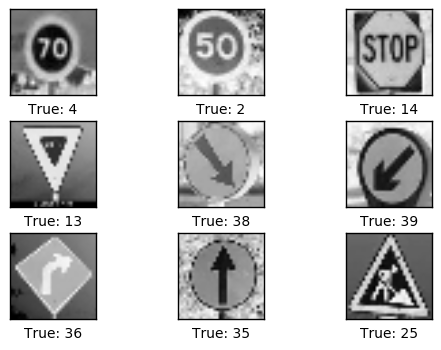

(9, 1024)


In [29]:
#load images
img1,img2,img3 = cv2.imread('test-image/1.jpg'),cv2.imread('test-image/2.jpg'),cv2.imread('test-image/3.jpg')  
img4,img5,img6 = cv2.imread('test-image/4.jpg'),cv2.imread('test-image/5.jpg'),cv2.imread('test-image/6.jpg')  
img7,img8,img9 = cv2.imread('test-image/7.jpg'),cv2.imread('test-image/8.jpg'),cv2.imread('test-image/9.jpg')  

img_test = np.array((img1,img2,img3,img4,img5,img6,img7,img8,img9))

#convert images
img_test_YUV = np.zeros_like(img_test)
img_test_Y = np.zeros((9,32,32))

for i in range(9):
    img_test_YUV[i] = cv2.cvtColor(img_test[i], cv2.COLOR_BGR2YUV)
    img_test_Y[i] = img_test_YUV[i][:,:,0]

img_test_Y = np.reshape(img_test_Y,(-1,1024))    


cls = [4,2,14,13,38,39,36,35,25]

plot_images(img_test_Y,cls)
plt.show()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.